In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # 去警告，如在缺省值处理中处理'Embarked'

train = pd.read_csv('D:/datas/titanic/train.csv') # ,keep_default_na=False
test = pd.read_csv('D:/datas/titanic/test.csv')

### 数据总览

In [2]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**发现有不少数据都有残缺的情况**

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**train一共有891行数据，Age，Cabin，Embarked都有残缺的情况**

In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
print('死亡率:',549/(549+342),'存活率:',342/(549+342))

死亡率: 0.6161616161616161 存活率: 0.3838383838383838


### 缺失值处理

**给Embarked赋众数**

In [6]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [7]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
# train[train.Embarked.isnull()]=
train.Embarked[train.Embarked.isnull()] = train.Embarked.dropna().mode().values

In [9]:
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

**大量Cabin为na，这种缺失的情况表明没有船舱，可以传'U0'**

In [10]:
train['Cabin'].fillna('U0',inplace=True) # 给na值赋值'U0',API上写是DataFrame的方法，但这里可以用在Series上，inplace直接在原对象上改

**用随机森林来给缺失的Age赋值**

In [11]:
from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train['Age'].notnull())]
age_df_isnull = age_df.loc[(train['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]

# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train.loc[train['Age'].isnull(), ['Age']]= predictAges

**查看处理完之后的数据**

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 分析数据关系

In [13]:
train.groupby(['Survived','Sex']).Name.count()
# 试一下这个，发现用什么都一样，所以用了Name。train.groupby(['Sex','Survived']).count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Name, dtype: int64

**男女的存活率分别为多少**

In [14]:
train.groupby(['Sex']).Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

0.742 = 233/(233+81)

如果想计算存活/死亡的人中，男女的比例，现在还没算

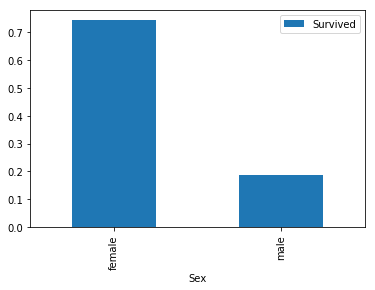

In [15]:
# train.groupby(['Sex']).Survived.mean().plot.bar()
train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

**船舱等级和存活率的关系**

In [16]:
train.Pclass.value_counts()
# train.Pclass.value_counts().plot.bar() 这居然成了

3    491
1    216
2    184
Name: Pclass, dtype: int64

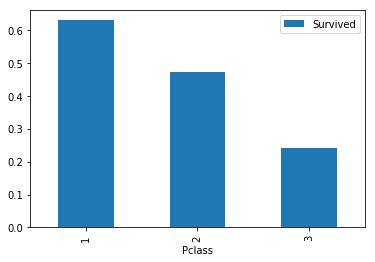

In [17]:
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

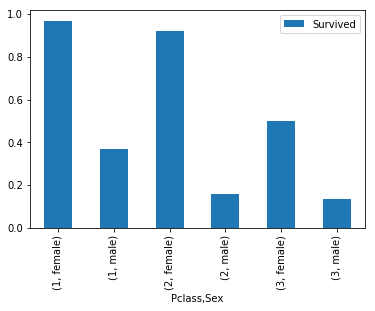

In [18]:
train[['Pclass','Survived','Sex']].groupby(['Pclass','Sex']).mean().plot.bar()

不同等级的船舱，不同性别的存活率

In [19]:
train.groupby(['Sex','Pclass','Survived']).Survived.count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

**年龄与存活率的关系**

In [20]:
'''
s = train['Age'].value_counts()
s.name='counts'
a = s.to_frame()
a['age'] = a.index
a.sort_values('age')
'''

"\ns = train['Age'].value_counts()\ns.name='counts'\na = s.to_frame()\na['age'] = a.index\na.sort_values('age')\n"

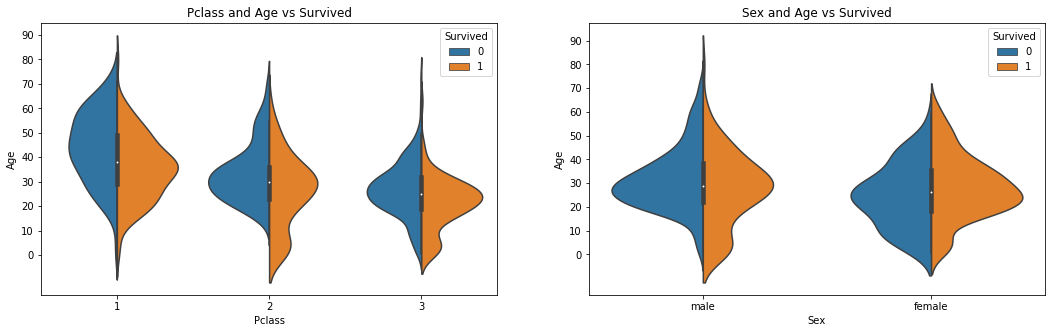

In [22]:
fig,ax = plt.subplots(1,2, figsize = (18,5))
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Pclass","Age",hue="Survived",data=train,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived') 

ax[1].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age",hue="Survived",data=train,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
 
plt.show()

小提琴图

接下来分析年龄分布 用hist图和boxplot图

boxplot的概念，参考https://zhuanlan.zhihu.com/p/34059825

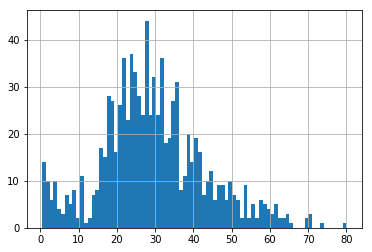

In [33]:
train['Age'].hist(bins=80)

**分析数据关系就先到这里**

### 变量转换

sklearn要求数据类型都是numeric，所以要进行转换

**定性（Qualitative）转换**

In [36]:
# train.info()

In [42]:
embark_dummies = pd.get_dummies(train['Embarked'])

In [43]:
embark_dummies.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


然后将原来的Embarked删除，换成了C Q S三列。这样做的目的是什么